In [74]:
import numpy as np
from PIL import Image
import os
import pandas as pd
import umap
import matplotlib.pyplot as plt
import shutil
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 14


In [208]:

# Wczytywanie zdjec
root_dir = '../ubiris_filtered'

image_data = []
folders = []
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)

    if os.path.isdir(folder_path):
        if len(os.listdir(folder_path)) >= 5:
            for file in os.listdir(folder_path):
                if file.endswith('.png'):
                    file_path = os.path.join(folder_path, file)

                    img = Image.open(file_path).convert('L')
                    img_array = np.array(img)

                    flattened_img_array = img_array.flatten()

                    image_data.append(flattened_img_array)
                    folders.append(folder)

In [209]:
# Create dataframe and save to file (takes a long time)
df = pd.DataFrame(image_data)
# df.to_csv("image_df.csv")

In [5]:
# Read dataframe from file
df = pd.read_csv("image_df.csv")
df.drop("Unnamed: 0", axis='columns', inplace=True)

In [210]:
df['Class'] = folders
df['Class'] = df["Class"].astype('int32')
df.dropna(inplace=True)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 13 to 13
Columns: 960401 entries, 0 to Class
dtypes: float64(955400), int32(1), uint8(5000)
memory usage: 7.3 MB


In [107]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,960391,960392,960393,960394,960395,960396,960397,960398,960399,Class
13,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [211]:
# UMAP
reducer = umap.UMAP()
reducer.fit(df.iloc[:, :-1])

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [212]:
# Create all embeddings and save to file
embedding_all = reducer.transform(df.iloc[:, :-1])
emb_df_all = pd.DataFrame(embedding_all)
emb_df_all["Class"] = df['Class'].tolist()
# emb_df_all.to_csv("embedding_df_all.csv")

In [45]:
# Read all embeddings from file
emb_df_all = pd.read_csv("embedding_df_all.csv")
emb_df_all.drop("Unnamed: 0", axis='columns', inplace=True)

In [46]:
emb_df_all.head()

,0,1,Class
0,-0.431628,3.293908,1
1,-0.480430,3.261544,1
2,0.583430,1.583725,1
3,0.179775,3.356953,1
4,1.623249,2.908846,1


In [7]:
import matplotlib

In [8]:
from itertools import combinations

In [9]:
cmap = matplotlib.colormaps['Paired']

In [10]:
mycmap = cmap(np.linspace(0, 1, 10))

In [11]:
def calculate_dispersion(group):
    return np.sqrt(np.var(group[0]) + np.var(group[1])) # If created manually
    # return np.sqrt(np.var(group['0']) + np.var(group['1']))  # If read from csv file

In [213]:
dispersion_per_class = emb_df_all.groupby('Class').apply(calculate_dispersion)

dispersion_df_all = pd.DataFrame({
    'class': dispersion_per_class.index,
    'dispersion': dispersion_per_class.values
})

In [ ]:
dispersion_df_all.describe()

In [ ]:
dispersion_df_all.describe()

In [13]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calculate_mean_distance(group):

    points = list(zip(group[0],group[1])) # If created manually
    # points = list(zip(group['0'],group['1'])) # If read from file
    distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
    avg_distance = sum(distances) / len(distances)
    return  avg_distance

In [214]:
mean_distance = emb_df_all.groupby('Class').apply(calculate_mean_distance)

mean_distance_df_all = pd.DataFrame({
    'class': mean_distance.index,
    'mean_distance': mean_distance.values
})

In [119]:
mean_distance_df_all.describe()

,class,mean_distance
count,49.000000,49.000000
mean,47.040816,0.631116
std,27.733824,0.626811
min,1.000000,0.073310
25%,20.000000,0.203315
50%,46.000000,0.297742
75%,71.000000,0.959137
max,90.000000,3.023074


In [56]:
mean_distance_df_all.describe()

,class,mean_distance
count,373.000000,373.000000
mean,208.890080,2.401217
std,120.784226,0.656308
min,1.000000,0.021339
25%,103.000000,1.964280
50%,209.000000,2.422976
75%,314.000000,2.844236
max,415.000000,4.145095


In [58]:
mask_good_classes_dist = mean_distance_df_all[(mean_distance_df_all["mean_distance"] < mean_distance_df_all.describe().loc['25%']['mean_distance'])]["class"].unique().tolist()

In [215]:
mask_good_classes_dist = mean_distance_df_all[(mean_distance_df_all["mean_distance"] < mean_distance_df_all.quantile(0.1)['mean_distance'])]["class"].unique().tolist()

In [178]:
mask_good_classes_dist = mean_distance_df_all[(mean_distance_df_all["mean_distance"] < mean_distance_df_all.quantile(0.45)['mean_distance'])]["class"].unique().tolist()

In [57]:
mask_good_classes_dispersion = dispersion_df_all[(dispersion_df_all["dispersion"] < dispersion_df_all.describe().loc["25%"]['dispersion'])]["class"].unique().tolist()

In [216]:
mask_good_classes_dispersion = dispersion_df_all[(dispersion_df_all["dispersion"] < dispersion_df_all.quantile(0.1)['dispersion'])]["class"].unique().tolist()

In [179]:
mask_good_classes_dispersion = dispersion_df_all[(dispersion_df_all["dispersion"] < dispersion_df_all.quantile(0.45)['dispersion'])]["class"].unique().tolist()

In [93]:
len(mask_good_classes_dispersion)

6

In [33]:
dispersion_df_all.quantile(0.1)['dispersion']

1.2861274480819702

In [31]:
dispersion_df_all.describe()

,class,dispersion
count,402.000000,402.000000
mean,261.791045,1.859483
std,150.866859,0.454120
min,1.000000,0.310552
25%,127.250000,1.583927
50%,254.500000,1.899999
75%,393.750000,2.185119
max,520.000000,3.102090


In [217]:
mask_good = set(mask_good_classes_dist).intersection(set(mask_good_classes_dispersion))
print(len(mask_good))

36


In [66]:
mask_good = mean_distance_df_all["class"].unique().tolist()
print(len(mask_good))

In [218]:
df_good = df.loc[df["Class"].isin(mask_good)]

In [219]:
embedding_good = reducer.transform(df_good.iloc[:, :-1])

In [220]:
emb_df_good = pd.DataFrame(embedding_good)
emb_df_good["Class"] = df_good['Class'].tolist()

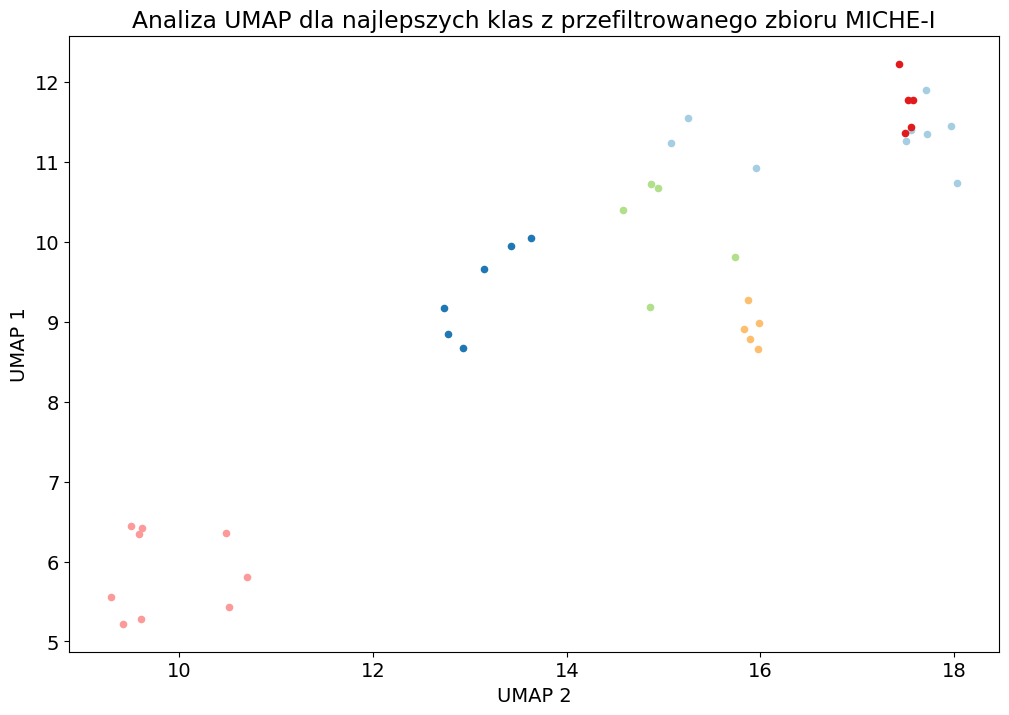

In [207]:
colors = df_good["Class"]
classes_unique = list(set(colors))[:40]
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=20)
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]

    plt.title("Analiza UMAP dla najlepszych klas z przefiltrowanego zbioru MICHE-I")
    plt.xlabel("UMAP 2")
    plt.ylabel("UMAP 1")
    plt.show()

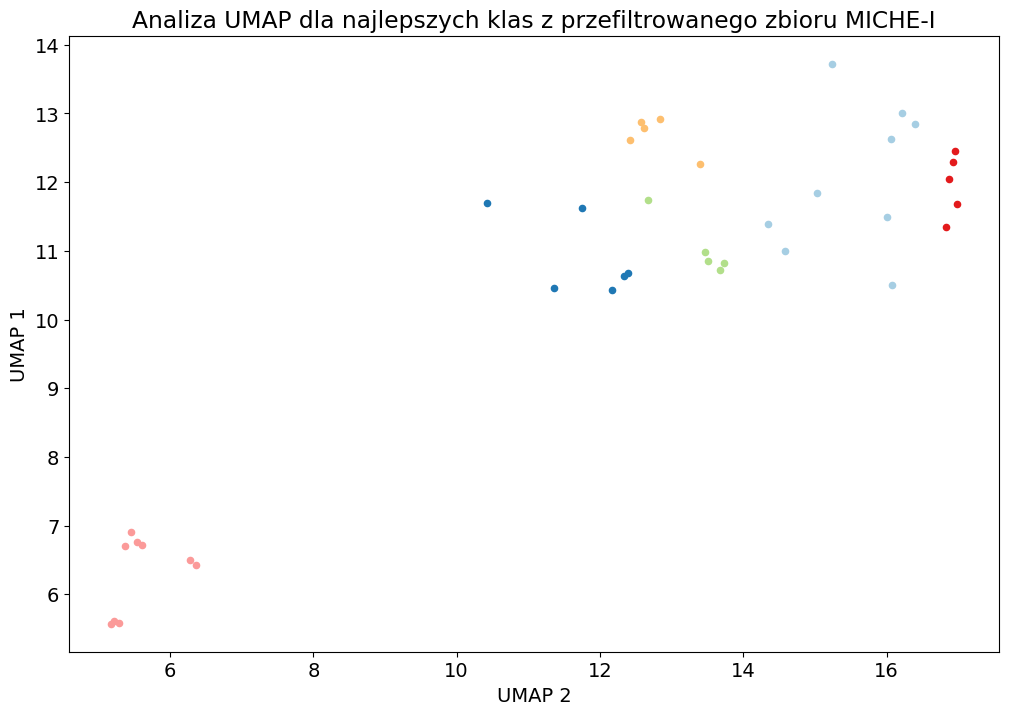

In [35]:
colors = df_good["Class"]
classes_unique = list(set(colors))[:40]
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=20)
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]

    plt.title("Analiza UMAP dla najlepszych klas z przefiltrowanego zbioru UBIRIS.v2")
    plt.xlabel("UMAP 2")
    plt.ylabel("UMAP 1")
    # plt.xlim([-3, 4.5])
    plt.show()

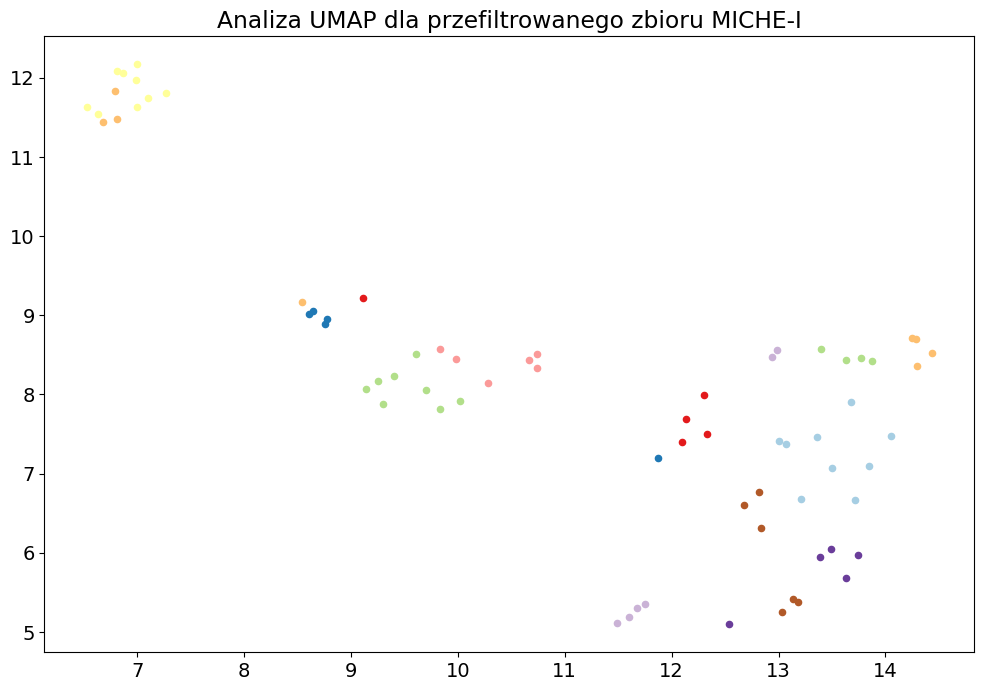

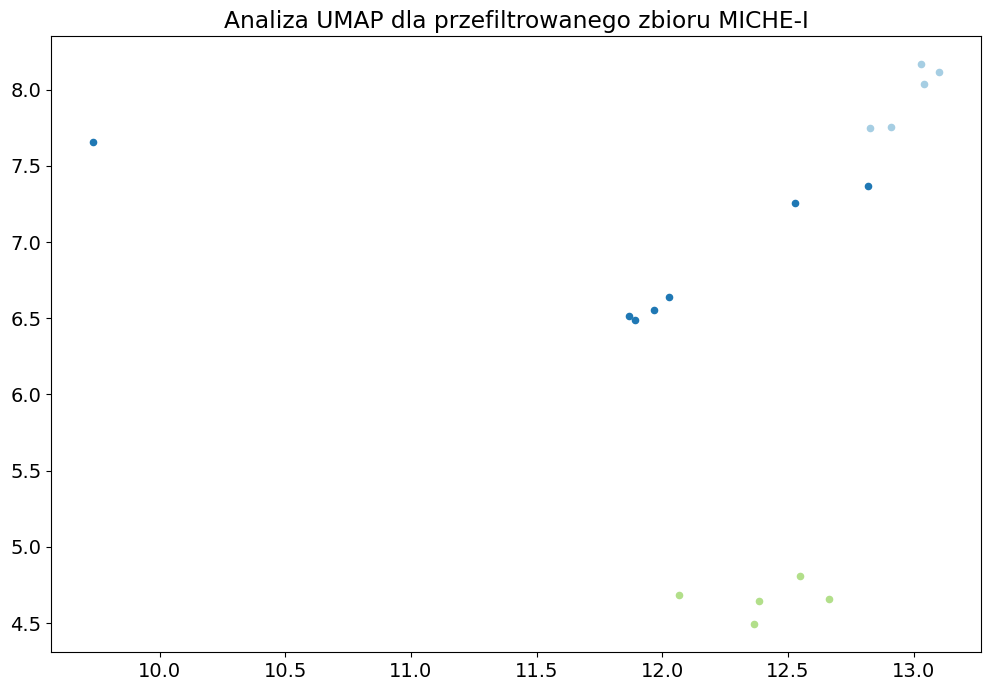

In [108]:
colors = df_good["Class"]
classes_unique = list(set(colors))[:40]
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=20)
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]

    plt.title("Analiza UMAP dla przefiltrowanego zbioru MICHE-I")
    # plt.xlim([-3, 4.5])
    plt.show()

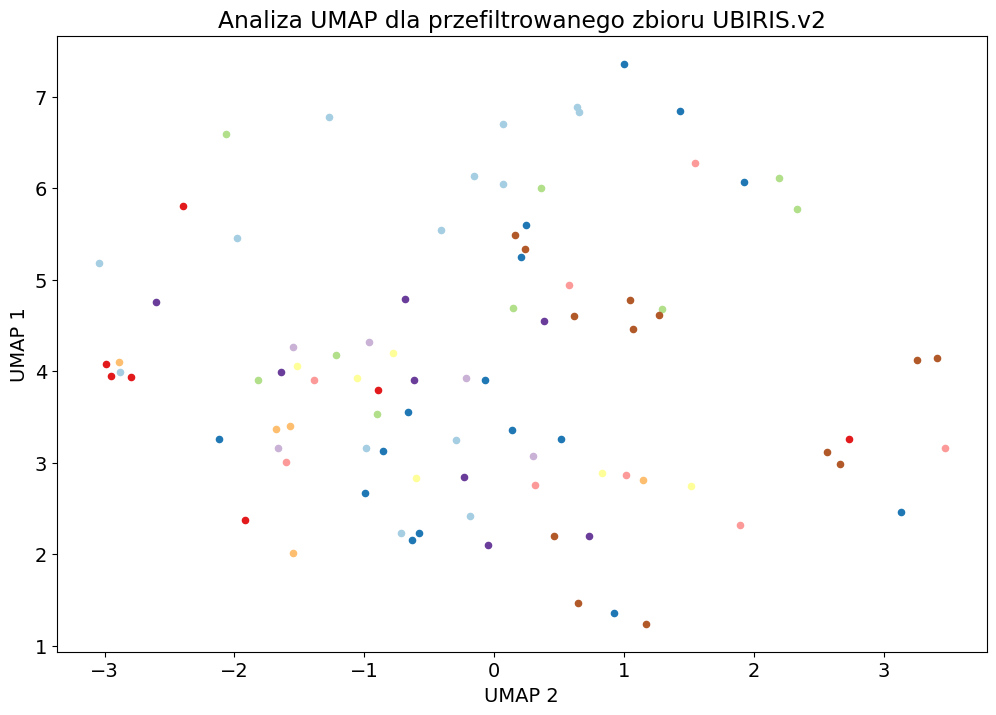

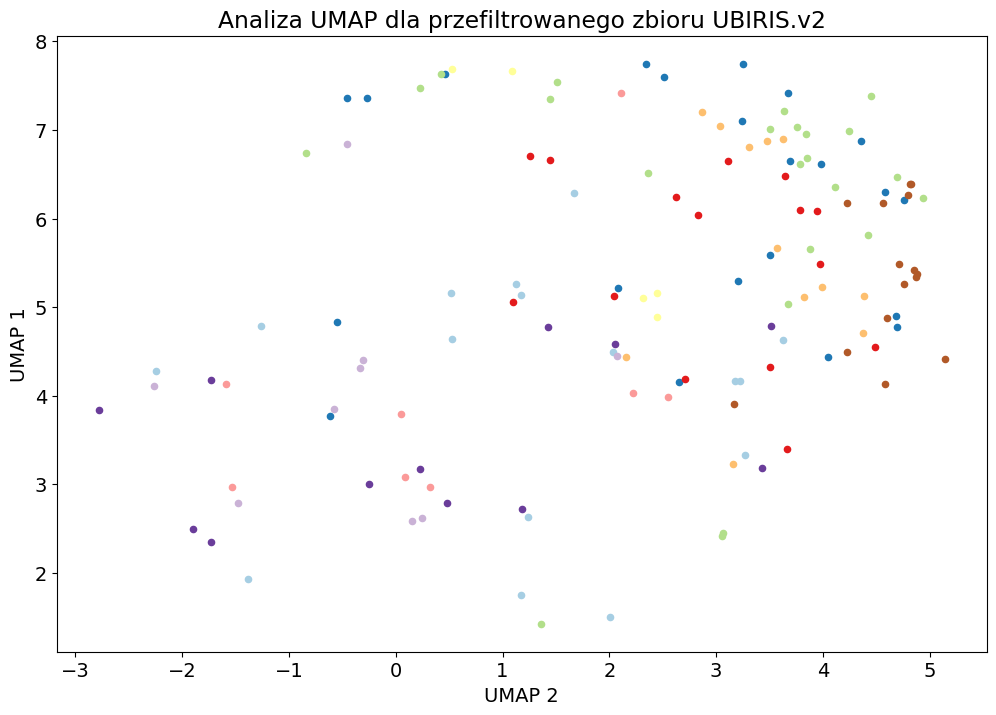

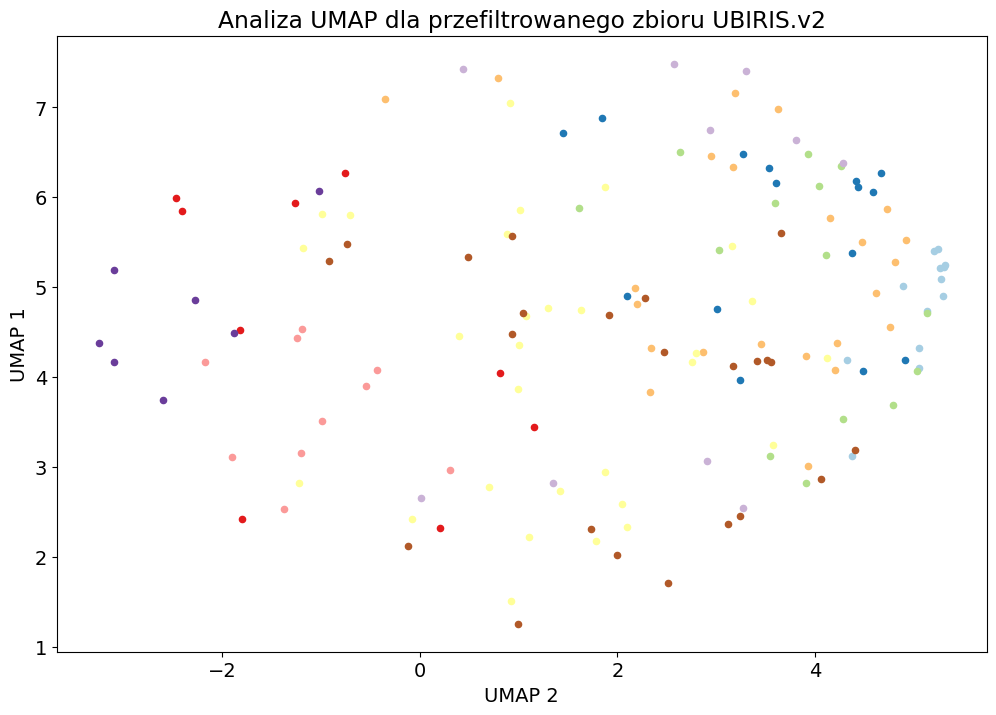

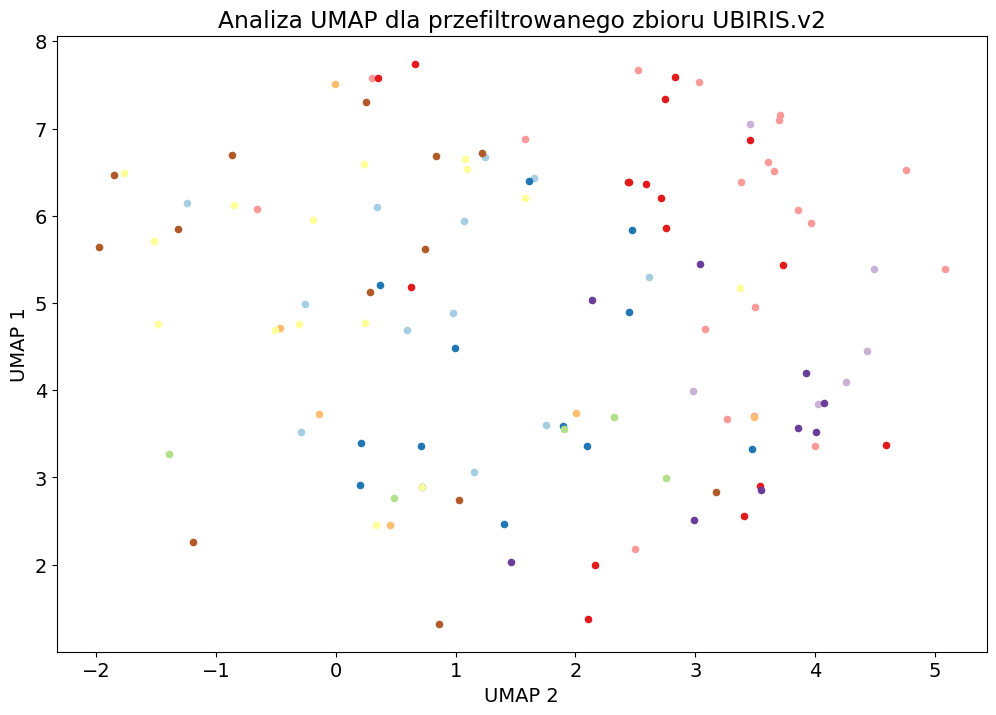

In [57]:
colors = df_good["Class"]
classes_unique = list(set(colors))[:40]
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=20)
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]

    plt.title("Analiza UMAP dla przefiltrowanego zbioru UBIRIS.v2")
    plt.xlabel("UMAP 2")
    plt.ylabel("UMAP 1")
    # plt.xlim([-3, 4.5])
    plt.show()

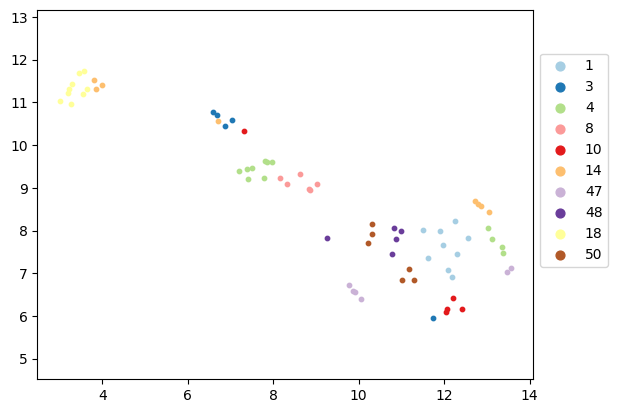

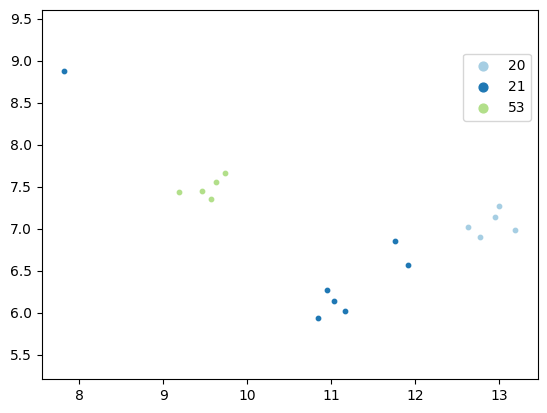

In [85]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=10)
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()

In [79]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=10)
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()

In [63]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=10)
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()

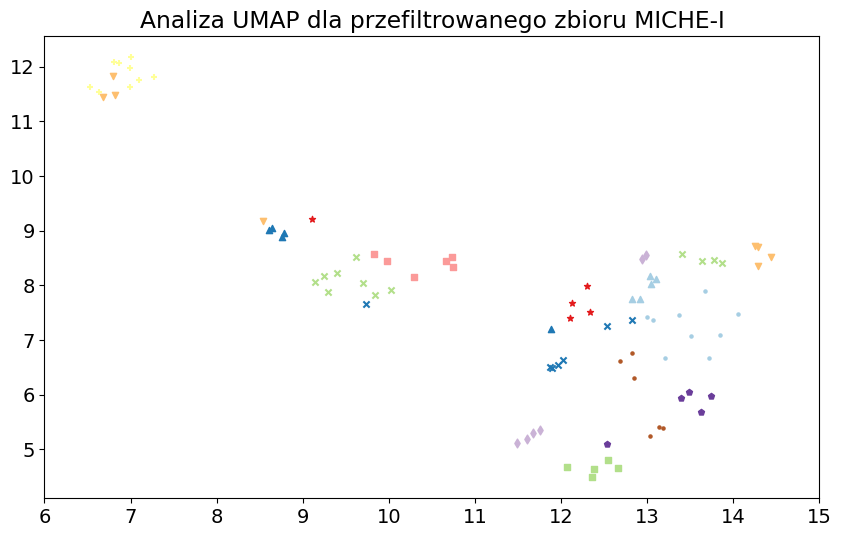

In [107]:
## MICHE
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

# chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=20,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]

    plt.title("Analiza UMAP dla przefiltrowanego zbioru MICHE-I")
    plt.xlim([6, 15])
    plt.show()

In [87]:
## MICHE
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

# chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=10,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()

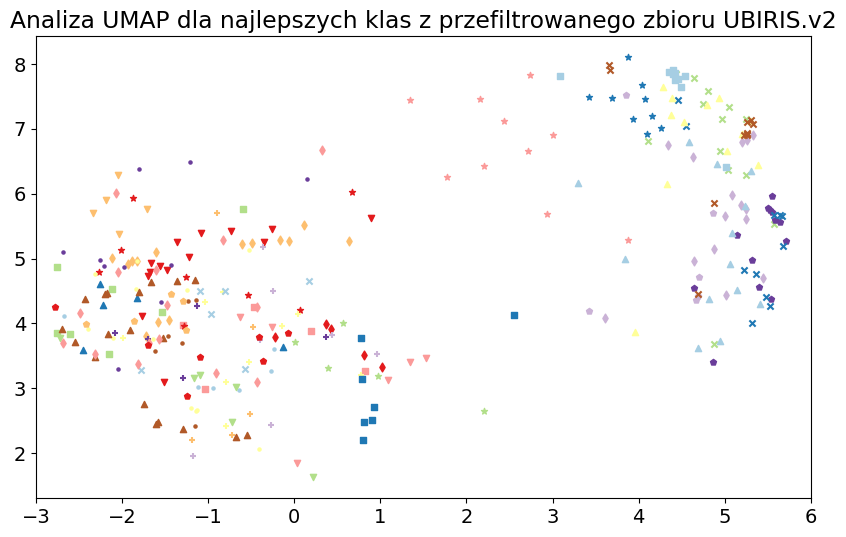

In [75]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

# chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=20,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]
    plt.title("Analiza UMAP dla najlepszych klas z przefiltrowanego zbioru UBIRIS.v2")
    plt.xlabel("UMAP 2")
    plt.ylabel("UMAP 1")
    # plt.xlim([-3, 6])
    plt.show()

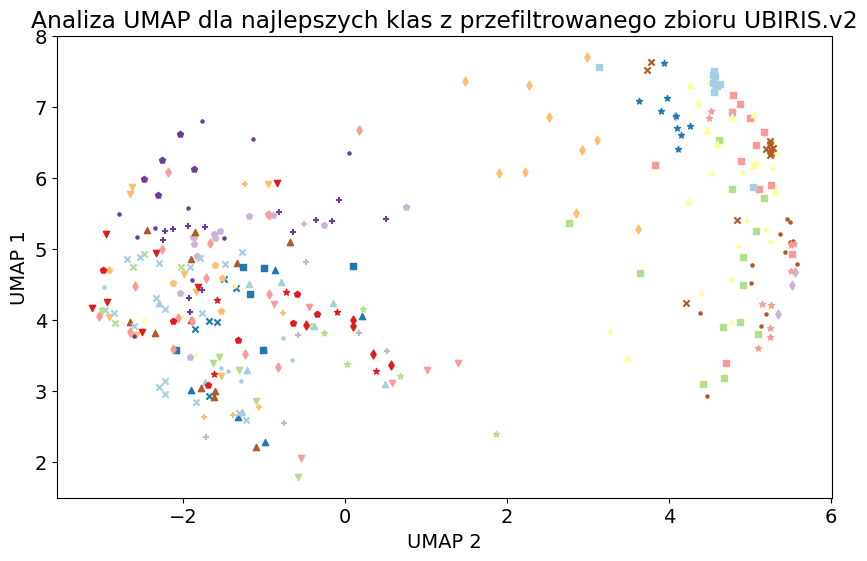

In [221]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

# chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=20,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]
    plt.title("Analiza UMAP dla najlepszych klas z przefiltrowanego zbioru UBIRIS.v2")
    plt.xlabel("UMAP 2")
    plt.ylabel("UMAP 1")
    # plt.xlim([-3, 6])
    plt.show()

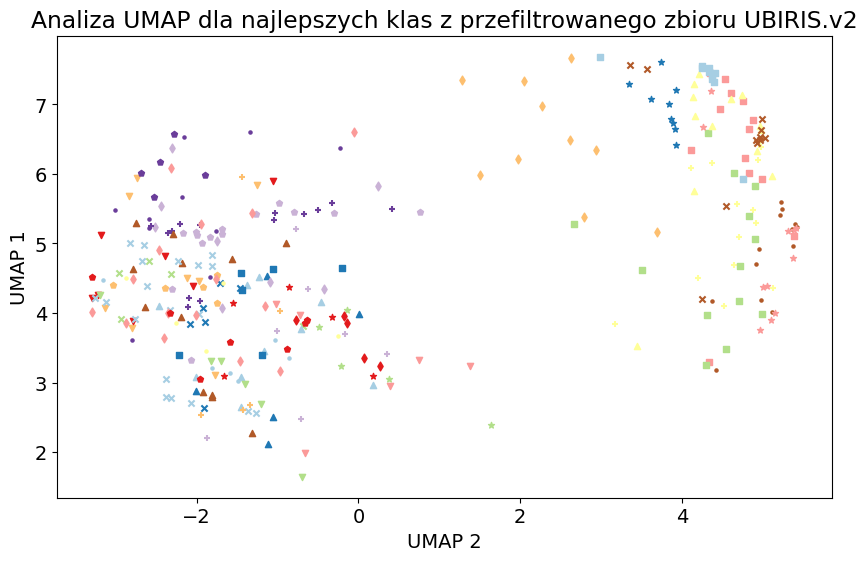

In [49]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

# chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=20,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]

    plt.title("Analiza UMAP dla najlepszych klas z przefiltrowanego zbioru UBIRIS.v2")
    plt.xlabel("UMAP 2")
    plt.ylabel("UMAP 1")
    plt.show()

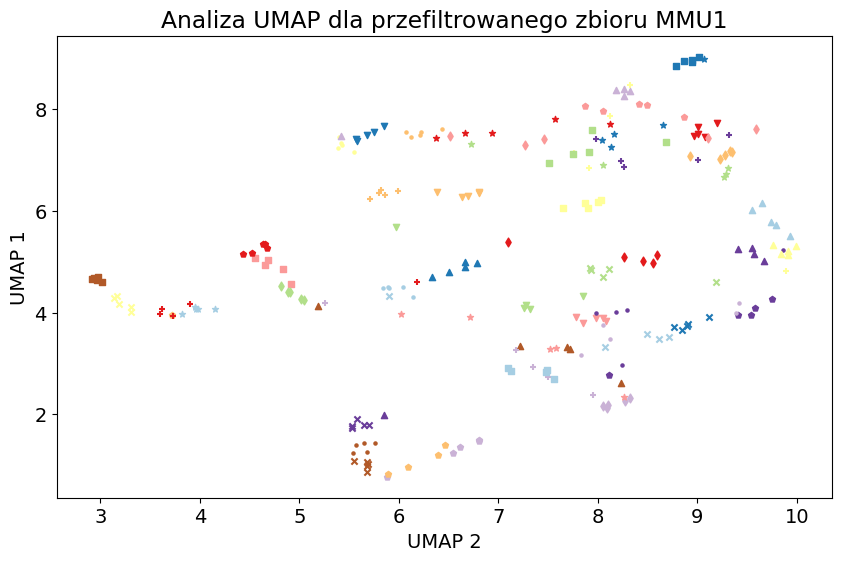

In [72]:
## MMU1
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=20,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    # plt.gca().set_aspect('equal', 'datalim')
    # lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    # for lgnhandle in lgnd.legend_handles:
    #     lgnhandle._sizes = [40]

plt.title("Analiza UMAP dla przefiltrowanego zbioru MMU1")
plt.xlabel("UMAP 2")
plt.ylabel("UMAP 1")
plt.show()

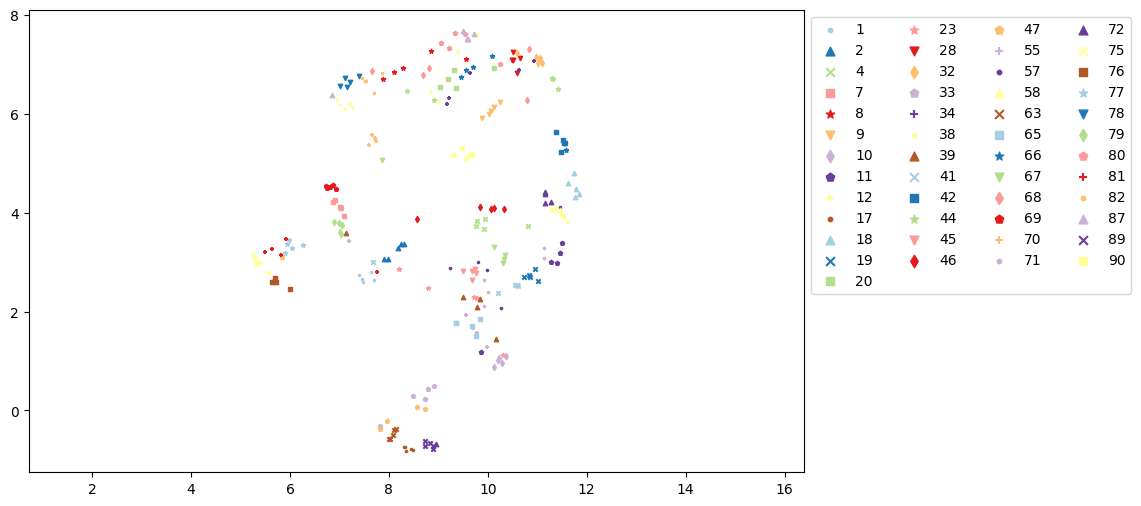

In [52]:
## MMU
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=10,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()

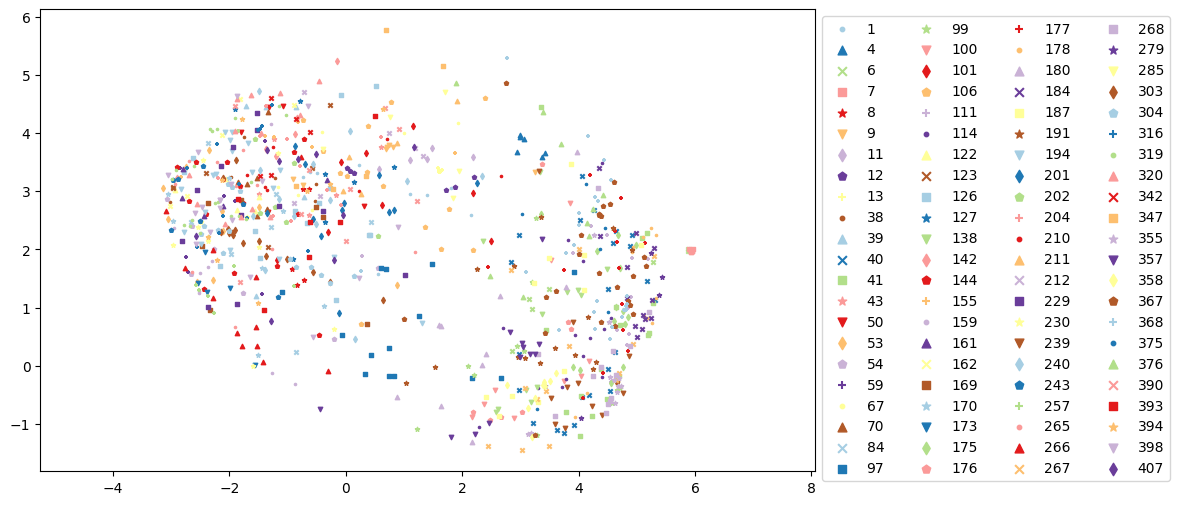

In [64]:
# ALL
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

# chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=10,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()